In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scandataset import SCANDataset
from scandataloader import SCANDataLoader
from transformer import Transformer
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_config.hyperparam_exp23 import *

In [2]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

device

'mps'

In [3]:
MAX_LEN = 50

src_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'walk',
    'look',
    'run',
    'jump',
    'turn',
    'left',
    'right',
    'and',
    'after',
    'opposite',
    'twice',
    'thrice',
    'around',
]

tgt_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'I_WALK',
    'I_RUN',
    'I_JUMP',
    'I_LOOK',
    'I_TURN_RIGHT',
    'I_TURN_LEFT'
]

def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}

src_vocab = list_to_dict(src_vocab)
tgt_vocab = list_to_dict(tgt_vocab)

paths = (
    os.path.join('data', 'length_split', f'tasks_train_length.txt'),
    os.path.join('data', 'length_split', f'tasks_test_length.txt')
)

scandataloader = SCANDataLoader()

In [4]:
def train_loop(model, optimizer, criterion, dataloader, epochs):
    model.train()
    
    for epoch in tqdm.tqdm(range(epochs)):
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss/len(dataloader):.4f}")

In [5]:
def sequence_length(seq):
    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]
    length = 0
    for token in seq:
        if token not in special_tokens:
            length += 1
    return length

In [6]:
def eval_loop(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0

    command_correct_tokens = {}
    command_total_tokens = {}
    action_correct_tokens = {}
    action_total_tokens = {}

    for i in range(1, MAX_LEN + 1):
        command_correct_tokens[i] = 0
        command_total_tokens[i] = 0
        action_correct_tokens[i] = 0
        action_total_tokens[i] = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                command_len = sequence_length(src[i])
                action_len = sequence_length(tgt[i])

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        command_total_tokens[command_len] += 1
                        action_total_tokens[action_len] += 1

                        if t == p:
                            correct_tokens += 1
                            command_correct_tokens[command_len] += 1
                            action_correct_tokens[action_len] += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    command_token_accuracies = {}
    action_token_accuracies = {}

    for k, v in command_correct_tokens.items():
        if command_total_tokens[k] != 0:
            command_token_accuracies[k] = v / command_total_tokens[k]

    for k, v in action_correct_tokens.items():
        if action_total_tokens[k] != 0:
            action_token_accuracies[k] = v / action_total_tokens[k]

    return (
        token_accuracy, 
        seq_accuracy, 
        command_token_accuracies, 
        action_token_accuracies
    )

In [7]:
def eval_loop_oracle(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0

    command_correct_tokens = {}
    command_total_tokens = {}
    action_correct_tokens = {}
    action_total_tokens = {}
    command_correct_seq = {}
    command_total_seq = {}
    action_correct_seq = {}
    action_total_seq = {}

    for i in range(1, MAX_LEN + 1):
        command_correct_tokens[i] = 0
        command_total_tokens[i] = 0
        action_correct_tokens[i] = 0
        action_total_tokens[i] = 0
        command_correct_seq[i] = 0
        command_total_seq[i] = 0
        action_correct_seq[i] = 0
        action_total_seq[i] = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            oracle_len = [sequence_length(seq) + 2 for seq in tgt]

            output = model.oracle_len_predict(src, start_token, end_token, oracle_len, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                command_len = sequence_length(src[i])
                action_len = sequence_length(tgt[i])

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        command_total_tokens[command_len] += 1
                        action_total_tokens[action_len] += 1

                        if t == p:
                            correct_tokens += 1
                            command_correct_tokens[command_len] += 1
                            action_correct_tokens[action_len] += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                    command_correct_seq[command_len] += 1
                    action_correct_seq[action_len] += 1
                
                total_seq += 1
                command_total_seq[command_len] += 1
                action_total_seq[action_len] += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    command_token_accuracies = {}
    action_token_accuracies = {}
    command_seq_accuracies = {}
    action_seq_accuracies = {}

    for k, v in command_correct_tokens.items():
        if command_total_tokens[k] != 0:
            command_token_accuracies[k] = v / command_total_tokens[k]

    for k, v in action_correct_tokens.items():
        if action_total_tokens[k] != 0:
            action_token_accuracies[k] = v / action_total_tokens[k]

    for k, v in command_correct_seq.items():
        if command_total_seq[k] != 0:
            command_seq_accuracies[k] = v / command_total_seq[k]

    for k, v in action_correct_seq.items():
        if action_total_seq[k] != 0:
            action_seq_accuracies[k] = v / action_total_seq[k]

    return (
        token_accuracy, 
        seq_accuracy, 
        command_token_accuracies, 
        action_token_accuracies, 
        command_seq_accuracies, 
        action_seq_accuracies
    )

In [ ]:
epochs = 2

train_path, test_path = paths

train_data = scandataloader.load_file_path(train_path)
test_data = scandataloader.load_file_path(test_path)

dataset_train = SCANDataset(
    data=train_data,
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    max_len=MAX_LEN,
)

dataset_test = SCANDataset(
    data=test_data,
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    max_len=MAX_LEN,
)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    src_pad_idx=src_vocab['<PAD>'],
    tgt_pad_idx=tgt_vocab['<PAD>'],
    emb_dim=EMB_DIM,
    num_layers=N_LAYERS,
    num_heads=N_HEADS,
    forward_dim=FORWARD_DIM,
    dropout=DROPOUT,
    max_len=MAX_LEN,
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

train_loop(model, optimizer, criterion, dataloader_train, epochs)

(
    token_accuracy, 
    seq_accuracy, 
    command_token_accuracies, 
    action_token_accuracies
) = eval_loop(model, dataloader_test)

print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

 50%|█████     | 1/2 [00:57<00:57, 57.82s/it]

Epoch 1, Loss: 0.6635


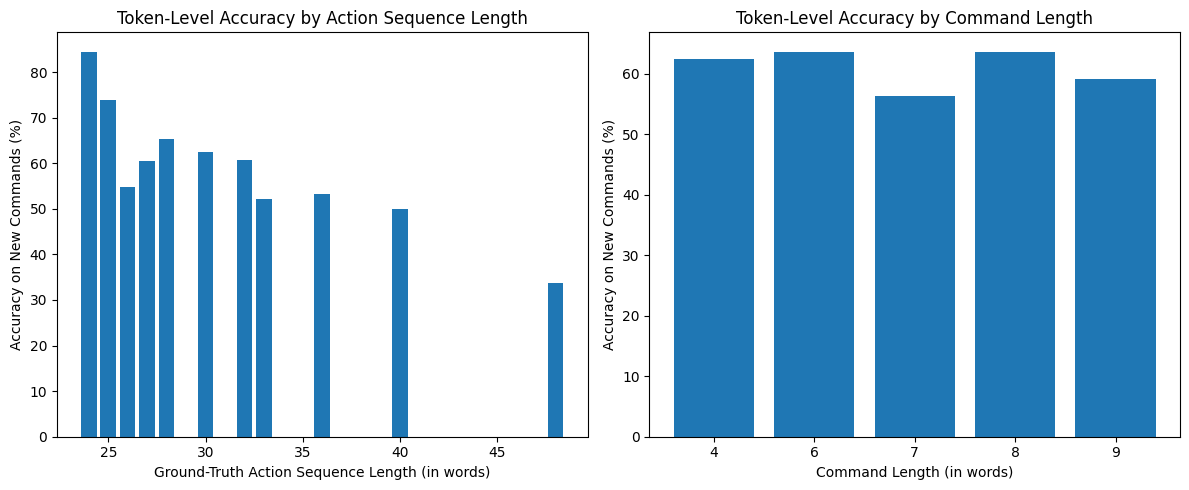

In [ ]:
command_lengths = []
command_accuracies = []
action_lengths = []
action_accuracies = []

for k, v in command_token_accuracies.items():
    command_lengths.append(k)
    command_accuracies.append(v * 100)

for k, v in action_token_accuracies.items():
    action_lengths.append(k)
    action_accuracies.append(v * 100)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(action_lengths, action_accuracies)
axes[0].set_title("Token-Level Accuracy by Action Sequence Length")
axes[0].set_xlabel("Ground-Truth Action Sequence Length (in words)")
axes[0].set_ylabel("Accuracy on New Commands (%)")

axes[1].bar(range(len(command_lengths)), command_accuracies, tick_label=command_lengths)
axes[1].set_title("Token-Level Accuracy by Command Length")
axes[1].set_xlabel("Command Length (in words)")
axes[1].set_ylabel("Accuracy on New Commands (%)")

plt.tight_layout()
plt.show()

In [10]:
(
    token_accuracy, 
    seq_accuracy, 
    command_token_accuracies, 
    action_token_accuracies, 
    command_seq_accuracies, 
    action_seq_accuracies
) = eval_loop_oracle(model, dataloader_test)

print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

Token-level accuracy: 0.7720146937086093, Sequence-level accuracy: 0.20816326530612245


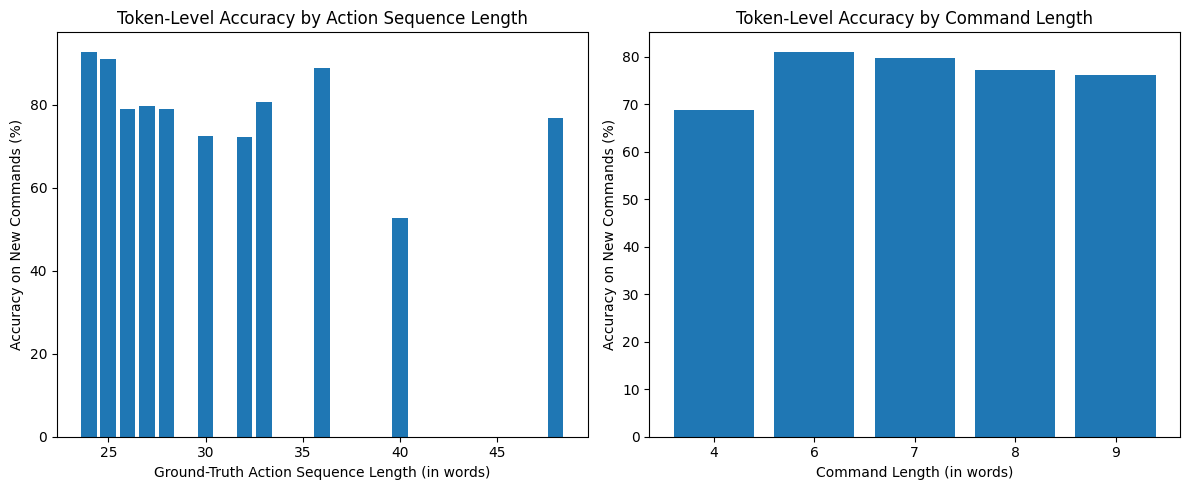

In [ ]:
command_lengths = []
command_accuracies = []
action_lengths = []
action_accuracies = []

for k, v in command_token_accuracies.items():
    command_lengths.append(k)
    command_accuracies.append(v * 100)

for k, v in action_token_accuracies.items():
    action_lengths.append(k)
    action_accuracies.append(v * 100)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(action_lengths, action_accuracies)
axes[0].set_title("Token-Level Accuracy by Action Sequence Length")
axes[0].set_xlabel("Ground-Truth Action Sequence Length (in words)")
axes[0].set_ylabel("Accuracy on New Commands (%)")

axes[1].bar(range(len(command_lengths)), command_accuracies, tick_label=command_lengths)
axes[1].set_title("Token-Level Accuracy by Command Length")
axes[1].set_xlabel("Command Length (in words)")
axes[1].set_ylabel("Accuracy on New Commands (%)")

plt.tight_layout()
plt.show()

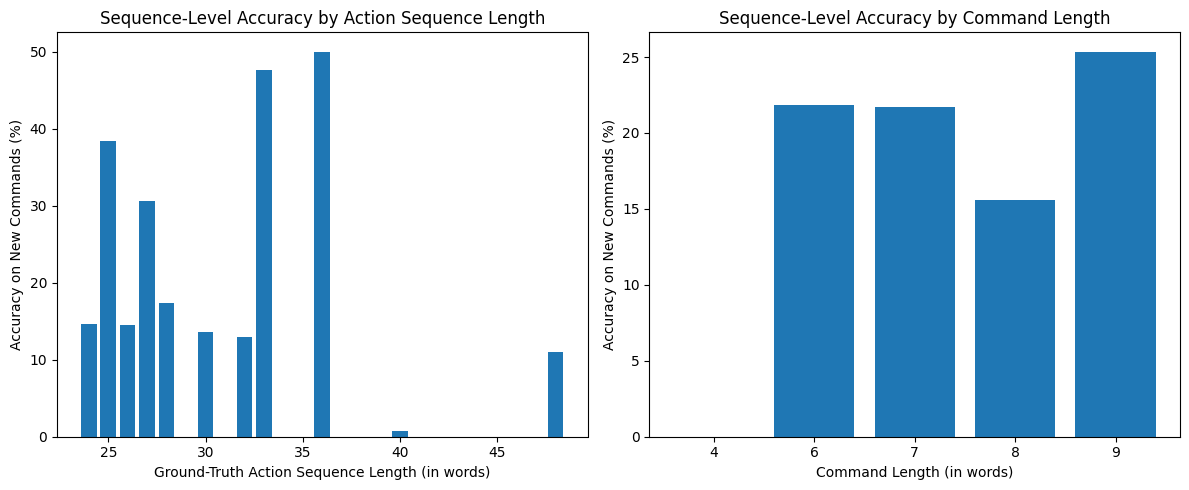

In [ ]:
command_lengths = []
command_accuracies = []
action_lengths = []
action_accuracies = []

for k, v in command_seq_accuracies.items():
    command_lengths.append(k)
    command_accuracies.append(v * 100)

for k, v in action_seq_accuracies.items():
    action_lengths.append(k)
    action_accuracies.append(v * 100)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(action_lengths, action_accuracies)
axes[0].set_title("Sequence-Level Accuracy by Action Sequence Length")
axes[0].set_xlabel("Ground-Truth Action Sequence Length (in words)")
axes[0].set_ylabel("Accuracy on New Commands (%)")

axes[1].bar(range(len(command_lengths)), command_accuracies, tick_label=command_lengths)
axes[1].set_title("Sequence-Level Accuracy by Command Length")
axes[1].set_xlabel("Command Length (in words)")
axes[1].set_ylabel("Accuracy on New Commands (%)")

plt.tight_layout()
plt.show()